<a href="https://colab.research.google.com/github/lcbjrrr/quant/blob/master/TimeSeries.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Time Series

## Imports

In [ ]:
import warnings
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import plotly as py
import datetime

from plotly.offline import init_notebook_mode, iplot
from pylab import rcParams

In [ ]:
warnings.filterwarnings('ignore')
plt.style.use('fivethirtyeight')
%matplotlib inline
init_notebook_mode(connected=True)

## Load DataFrames

In [ ]:
google = pd.read_csv('data/google_traffic.csv')

In [ ]:
climate = pd.read_csv('data/climate.csv', index_col='date', parse_dates=['date'])

In [ ]:
stocks = pd.read_csv('data/stocks.csv', index_col='datetime', parse_dates=['datetime'])

## Cleaning and Preparing data

In [ ]:
climate.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1462 entries, 2013-01-01 to 2017-01-01
Data columns (total 4 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   meantemp      1462 non-null   float64
 1   humidity      1462 non-null   float64
 2   wind_speed    1462 non-null   float64
 3   meanpressure  1462 non-null   float64
dtypes: float64(4)
memory usage: 57.1 KB


Checking if data is complete 

In [ ]:
first = datetime.datetime(2013, 1, 1)
last = datetime.datetime(2017, 1, 2)
difference = last - first
difference.days

1462

Checking stocks dataframe

In [ ]:
stocks.head(2)

,ticker,open,close,high,low,volume
datetime,,,,,,
1994-07-04,ACE 3,48.00,48.0,48.0,47.00,46550.0
1994-07-04,ALP 3,155.27,156.0,156.0,155.27,163405.8


In [ ]:
'PETR4' in stocks.ticker.unique()

True

In [ ]:
stocks.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1883203 entries, 1994-07-04 to 2020-12-28
Data columns (total 6 columns):
 #   Column  Dtype  
---  ------  -----  
 0   ticker  object 
 1   open    float64
 2   close   float64
 3   high    float64
 4   low     float64
 5   volume  float64
dtypes: float64(5), object(1)
memory usage: 100.6+ MB


In [ ]:
all_tickers = stocks['ticker'].unique()
print('Total of tickers: ', len(all_tickers))

Total of tickers:  3397


In [ ]:
tickers_incomplete = []
for ticker in all_tickers[:10]:
    ticker_stock = stocks[stocks['ticker'] == ticker]
    ticker_stock = ticker_stock.sort_values(by=['datetime'])
    
    first_time = pd.to_datetime(ticker_stock.iloc[[0]].index[0]).date()
    last_time = pd.to_datetime(ticker_stock.iloc[[-1]].index[0]).date()
    busy_days = np.busday_count(first_time, last_time)

#     print('Len: ', len(ticker_stock))
#     print('Total: ', np.busday_count(first_time, last_time))
    if busy_days != len(ticker_stock):
        tickers_incomplete.append(ticker)
len(tickers_incomplete)

10

In [ ]:
stocks[(stocks['ticker'] == 'ALP 3') &
       (stocks.index >= '1994-07-01') &
       (stocks.index <= '1994-07-30')
]

,ticker,open,close,high,low,volume
datetime,,,,,,
1994-07-04,ALP 3,155.27,156.00,156.00,155.27,163405.8
1994-07-06,ALP 3,145.01,160.00,160.00,145.01,32001.0
1994-07-07,ALP 3,169.99,169.98,169.99,153.50,16309.3
1994-07-12,ALP 3,164.50,164.50,164.50,164.50,1645.0
1994-07-13,ALP 3,163.60,163.60,163.60,163.60,1636.0
1994-07-26,ALP 3,160.00,160.00,160.00,159.00,3146327.6
1994-07-27,ALP 3,159.99,179.99,179.99,159.99,11399.8
1994-07-28,ALP 3,191.00,191.00,191.00,191.00,1910.0
1994-07-29,ALP 3,188.00,209.50,209.50,188.00,5974.9


Almost every data from the stocks dataframe has a problem with missing values (but not with an `nan` value), so we will apply some techniques to resample the data.

In [ ]:
ticker_filter = stocks[
    (stocks.index >= '2019-01-01') &
    (stocks.index <= '2021-01-01')
]['ticker'].unique()

all_new_stock_ticker = []
for ticker in ticker_filter:
    stock_ticker = stocks[stocks['ticker'] == ticker]
    new_stock_ticker = (stock_ticker
        .groupby(['ticker']).resample('D').sum().reset_index(
        ).set_index('datetime')
    )
    all_new_stock_ticker.append(new_stock_ticker)

stocks_resampled = pd.concat(all_new_stock_ticker)
stocks_resampled[stocks_resampled['ticker'] == 'AALR3']

,ticker,open,close,high,low,volume
datetime,,,,,,
2016-10-28,AALR3,19.30,19.20,19.76,18.92,122334647.0
2016-10-29,AALR3,0.00,0.00,0.00,0.00,0.0
2016-10-30,AALR3,0.00,0.00,0.00,0.00,0.0
2016-10-31,AALR3,19.19,18.06,19.20,17.51,45857231.0
2016-11-01,AALR3,18.06,17.90,18.38,17.16,17676981.0
...,...,...,...,...,...,...
2020-12-26,AALR3,0.00,0.00,0.00,0.00,0.0
2020-12-27,AALR3,0.00,0.00,0.00,0.00,0.0
2020-12-28,AALR3,11.05,11.01,11.13,10.82,5680681.0


In [ ]:
stocks_resampled[(stocks_resampled.ticker == 'AALR3') &
    (stocks_resampled.index >= '2019-01-01') &
    (stocks_resampled.index <= '2019-02-01')]

,ticker,open,close,high,low,volume
datetime,,,,,,
2019-01-01,AALR3,0.00,0.00,0.00,0.00,0.0
2019-01-02,AALR3,13.31,13.25,13.50,13.25,3523962.0
2019-01-03,AALR3,13.21,13.30,13.65,13.21,1684930.0
2019-01-04,AALR3,13.49,13.44,13.59,13.33,1944352.0
2019-01-05,AALR3,0.00,0.00,0.00,0.00,0.0
2019-01-06,AALR3,0.00,0.00,0.00,0.00,0.0
2019-01-07,AALR3,13.43,13.34,13.58,13.32,1566187.0
2019-01-08,AALR3,13.30,13.19,13.30,13.06,1625791.0
2019-01-09,AALR3,13.23,13.14,13.23,13.10,1305109.0


So now we have all our stocks resampled using an technique of fill 0

Analysing the google web traffic series, we can use another methods of filling the `nan` and missing values.

In [ ]:
google

,Page,2015-07-01,2015-07-02,2015-07-03,2015-07-04,2015-07-05,2015-07-06,2015-07-07,2015-07-08,2015-07-09,...,2016-12-22,2016-12-23,2016-12-24,2016-12-25,2016-12-26,2016-12-27,2016-12-28,2016-12-29,2016-12-30,2016-12-31
0,2NE1_zh.wikipedia.org_all-access_spider,18.0,11.0,5.0,13.0,14.0,9.0,9.0,22.0,26.0,...,32.0,63.0,15.0,26.0,14.0,20.0,22.0,19.0,18.0,20.0
1,2PM_zh.wikipedia.org_all-access_spider,11.0,14.0,15.0,18.0,11.0,13.0,22.0,11.0,10.0,...,17.0,42.0,28.0,15.0,9.0,30.0,52.0,45.0,26.0,20.0
2,3C_zh.wikipedia.org_all-access_spider,1.0,0.0,1.0,1.0,0.0,4.0,0.0,3.0,4.0,...,3.0,1.0,1.0,7.0,4.0,4.0,6.0,3.0,4.0,17.0
3,4minute_zh.wikipedia.org_all-access_spider,35.0,13.0,10.0,94.0,4.0,26.0,14.0,9.0,11.0,...,32.0,10.0,26.0,27.0,16.0,11.0,17.0,19.0,10.0,11.0
4,52_Hz_I_Love_You_zh.wikipedia.org_all-access_s...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,48.0,9.0,25.0,13.0,3.0,11.0,27.0,13.0,36.0,10.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
145058,Underworld_(serie_de_películas)_es.wikipedia.o...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,13.0,12.0,13.0,3.0,5.0,10.0
145059,Resident_Evil:_Capítulo_Final_es.wikipedia.org...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
145060,Enamorándome_de_Ramón_es.wikipedia.org_all-acc...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
145061,Hasta_el_último_hombre_es.wikipedia.org_all-ac...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


We can apply a lot of fill [methods](https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.fillna.html) from pandas 

In [ ]:
google_resampled = google.fillna(method='ffill')
test = google.loc[145058].fillna(method='ffill')
print(google.loc[145058].values)
print(google_resampled.loc[145058].values)
print(test.values)

['Underworld_(serie_de_películas)_es.wikipedia.org_all-access_spider' nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan n

In [ ]:
google_transpose = google.loc[:10].T
google_transpose.columns = google_transpose.iloc[0]
google_transpose = google_transpose[1:]
google_transpose = google_transpose.rename_axis('date')

In [ ]:
google_transpose

Page,2NE1_zh.wikipedia.org_all-access_spider,2PM_zh.wikipedia.org_all-access_spider,3C_zh.wikipedia.org_all-access_spider,4minute_zh.wikipedia.org_all-access_spider,52_Hz_I_Love_You_zh.wikipedia.org_all-access_spider,5566_zh.wikipedia.org_all-access_spider,91Days_zh.wikipedia.org_all-access_spider,A'N'D_zh.wikipedia.org_all-access_spider,AKB48_zh.wikipedia.org_all-access_spider,ASCII_zh.wikipedia.org_all-access_spider,ASTRO_zh.wikipedia.org_all-access_spider
date,,,,,,,,,,,
2015-07-01,18,11,1,35,NaN,12,NaN,118,5,6,NaN
2015-07-02,11,14,0,13,NaN,7,NaN,26,23,3,NaN
2015-07-03,5,15,1,10,NaN,4,NaN,30,14,5,NaN
2015-07-04,13,18,1,94,NaN,5,NaN,24,12,12,NaN
2015-07-05,14,11,0,4,NaN,20,NaN,29,9,6,NaN
...,...,...,...,...,...,...,...,...,...,...,...
2016-12-27,20,30,4,11,11,19,4,23,30,29,14
2016-12-28,22,52,6,17,27,23,15,32,36,35,10
2016-12-29,19,45,3,19,13,17,6,39,38,44,38


In [ ]:
column_name = '91Days_zh.wikipedia.org_all-access_spider'
google_transpose.loc['2016-06-01':'2016-07-10', column_name]
# google_transpose.loc['2016-06-01':'2016-07-10', column_name].fillna(method='bfill')

## Visualizing

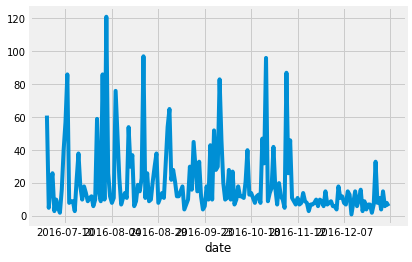

In [ ]:
google_transpose[column_name].plot()

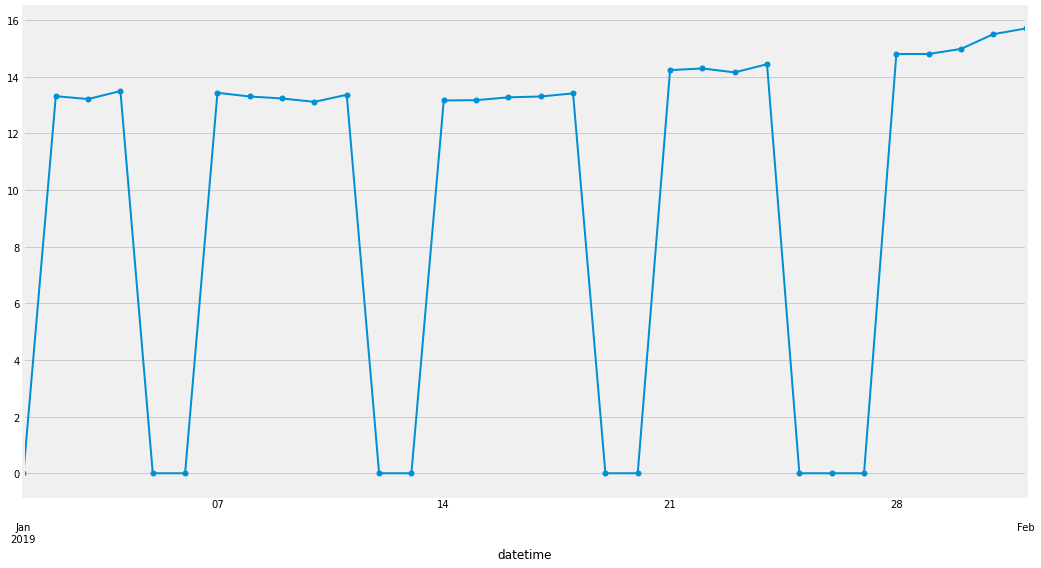

In [ ]:
plt.figure(figsize=(16, 9))

stocks_resampled[(stocks_resampled.ticker == 'AALR3') &
    (stocks_resampled.index >= '2019-01-01') &
    (stocks_resampled.index <= '2019-02-01')]['open'].plot(marker='.', markersize=10, linewidth=2)

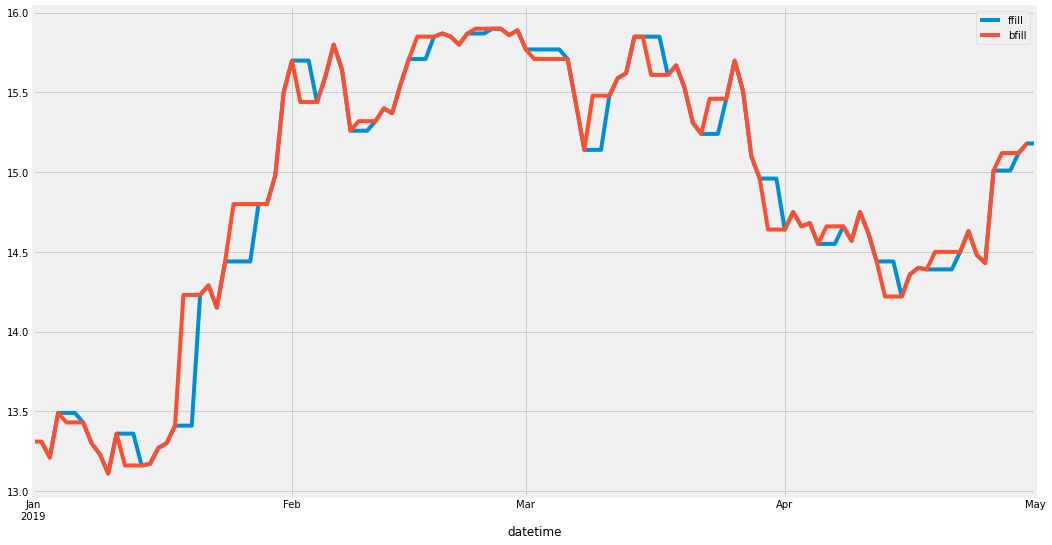

In [ ]:
plt.figure(figsize=(16, 9))

AALR3 = stocks_resampled[(stocks_resampled.ticker == 'AALR3') &
    (stocks_resampled.index >= '2019-01-01') &
    (stocks_resampled.index <= '2019-05-01')]
AALR3_resampled = AALR3['open'].replace(0.0, np.nan)
AALR3_resampled.ffill().plot()
AALR3_resampled.bfill().plot()
plt.legend(['ffill', 'bfill'])
plt.show()

## Shifting and lag

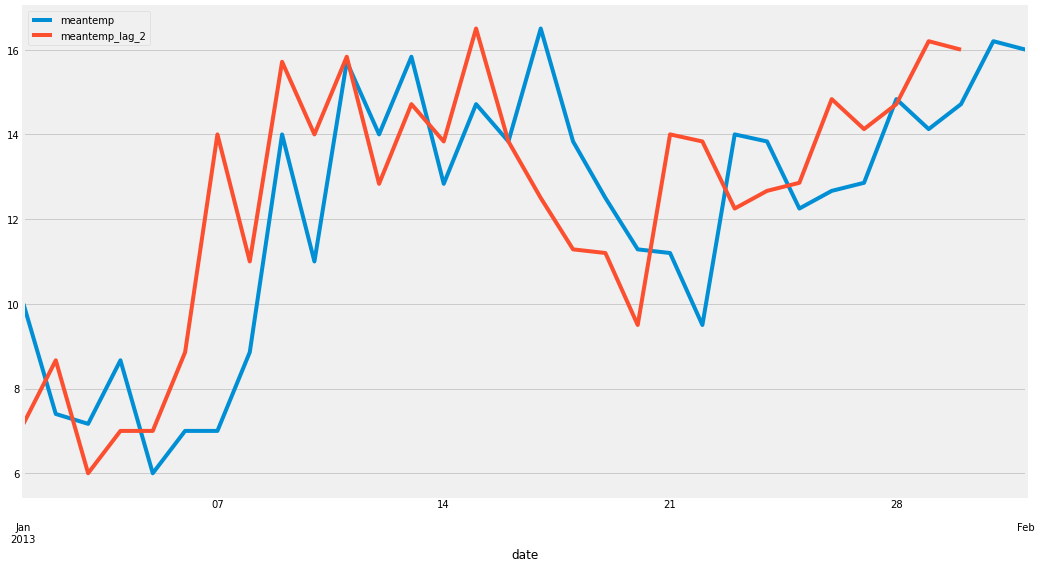

In [ ]:
plt.figure(figsize=(16, 9))
lag = 2
climate.loc['2013-01-01':'2013-02-01', 'meantemp'].plot(legend=True)
climate.loc['2013-01-01':'2013-02-01', 'meantemp'].shift(-lag).plot(legend=True)
plt.legend(['meantemp', f'meantemp_lag_{lag}'])
plt.show()

## Autocorrelation

Using this autocorrelation we can define which lag has more correlation with one variable

In [ ]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

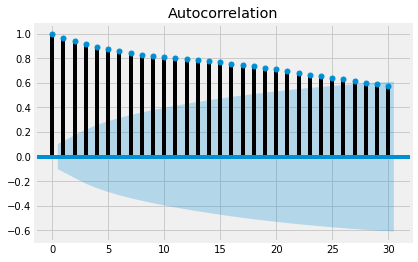

In [ ]:
plot_acf(climate.loc['2013-01-01':'2014-01-01', 'meantemp'], lags=30)
plt.show()

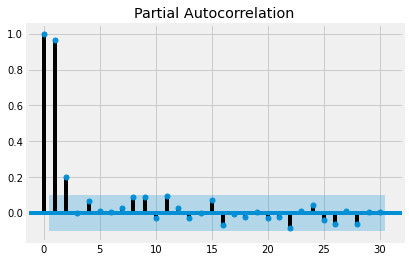

In [ ]:
plot_pacf(climate.loc['2013-01-01':'2014-01-01', 'meantemp'], lags=30)
plt.show()

## Comparing Time series

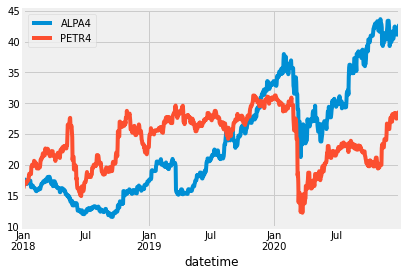

In [ ]:
alpa = stocks_resampled[stocks_resampled['ticker'] == 'ALPA4'].replace(0, np.nan).fillna(method='ffill')
alpa_2018 = alpa.loc['2018-01-01':]
petro = stocks_resampled[stocks_resampled['ticker'] == 'PETR4'].replace(0, np.nan).fillna(method='ffill')
petro_2018 = petro.loc['2018-01-01':]

alpa_2018['high'].plot()
petro_2018['high'].plot()
plt.legend(['ALPA4', 'PETR4'])
plt.show()

### Correlation

In [ ]:
alpa_2020 = alpa_2018.loc['2020-01-01':]
petro_2020 = petro_2018.loc['2020-01-01':]

np.corrcoef(alpa_2020.high, petro_2020.high)

array([[1.        , 0.50841238],
       [0.50841238, 1.        ]])

### SOFT-DTW

In [ ]:
from tslearn.metrics import soft_dtw

In [ ]:
soft_dtw(alpa_2020.high, petro_2020.high, gamma=0.01)

22892.076505438337

## Window functions

Used to calculate the mean average

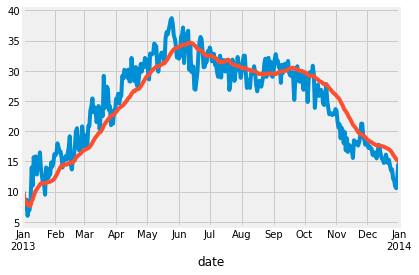

In [ ]:
rolling_climate = climate.loc['2013-01-01':'2014-01-01', 'meantemp'].rolling('30D').mean()
climate.loc['2013-01-01':'2014-01-01', 'meantemp'].plot()
rolling_climate.plot()

## Time series decomposition

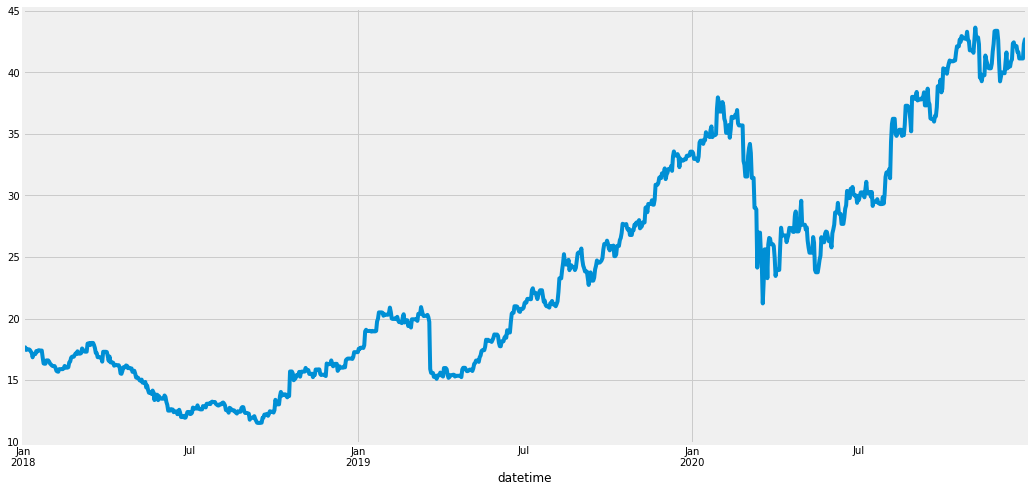

In [ ]:
alpa_2018.high.plot(figsize=(16, 8))

In [ ]:
import statsmodels.api as sm

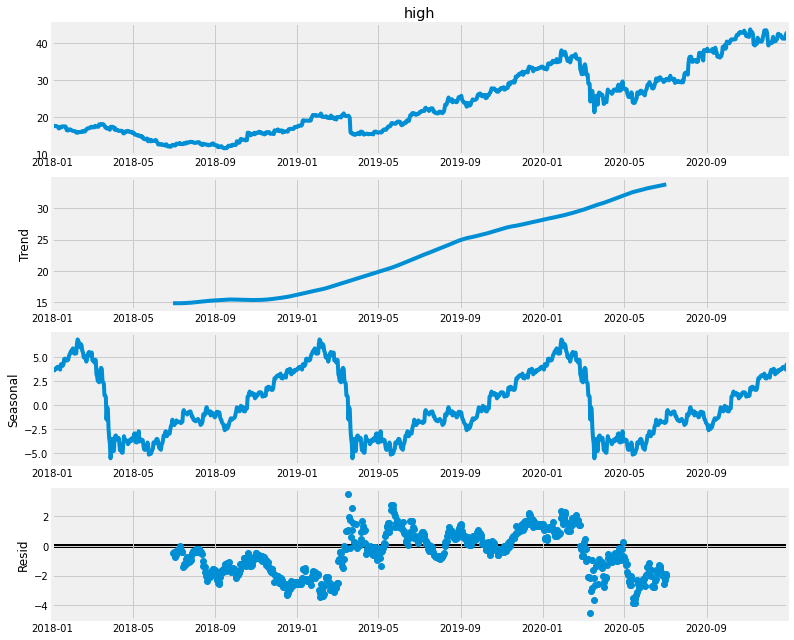

In [ ]:
rcParams['figure.figsize'] = 11, 9

decomposed_alpa = sm.tsa.seasonal_decompose(alpa_2018.high, freq=360) # frequency annual
decomposed_alpa.plot()
plt.show()

### Trend
- upwards or downwards slope of a time series (can be related to stationarity)

### Seasonality
- Clear periodic pattern of a time series

### Noise
- Outliers or missing values

### Stationarity
Statistical properties (mean, variance, autocorrelation, etc.) are constants over time
- **Strong:** stochastic process whose unconditional joint probability distribuition dos not change when shifted in time.
- **Weak:** stochastic process where mean, variance, autocorrelation are constant through the time

## Finance

### Percent change

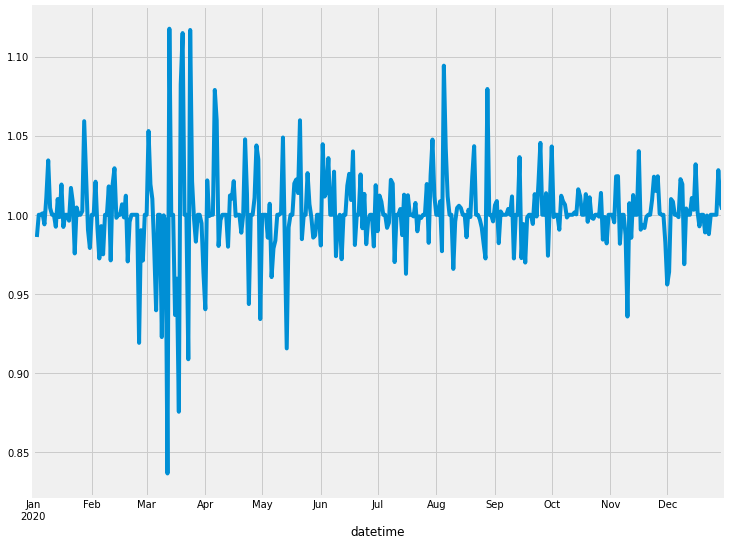

In [ ]:
alpa = stocks_resampled[stocks_resampled['ticker'] == 'ALPA4'].replace(0, np.nan)
alpa_2020 = alpa.loc['2020-01-01':'2021-01-01'].fillna(method='ffill')
alpa_2020['change'] = alpa_2020['high'].div(alpa_2020['high'].shift(1))
# alpa_2020['open'].fillna(method='ffill').plot()
# alpa['open'].fillna(method='ffill').plot()
alpa_2020['change'].plot()